In [47]:
import os
import re
import numpy as np
import pandas as pd
import sklearn
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')


from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.utils import class_weight



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
olid_data = pd.read_csv("data/OLIDv1/olid-training-v1.0.tsv", sep='\t')


In [59]:
def preprocess(sent, lemmatizer, stop_words):
    
    alphabet = "abcdefghijklmnopqrstuvwxyz 0123456789',."
    sent = sent.lower()
    sent = sent.replace('@user','')
    sent = sent.replace('@[\w\-]+','')

    #cleaned_sent_list = [char if char in alphabet else ' ' for char in sent] # remove all tags not in the alphabet

    #cleaned_sent = ''.join(cleaned_sent_list)
    sent=sent.replace('@user','')
    sent=sent.replace('@[\w\-]+','')
    #x=x.translate(str.maketrans('', '', string.punctuation))
    sent = re.sub('[^A-Za-z]', ' ', sent)
    #x=re.sub('\s+',' ',x)
    cleaned_sent=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',sent)
    cleaned_sent = cleaned_sent.replace("n't",' not') # replace words like "isn't" with "is not"
    cleaned_sent = ' . '.join([x for x in cleaned_sent.split('.') if len(x)>0]) # remove multiple periods, and add spaces before and after a period
    cleaned_sent = ' , '.join([x for x in cleaned_sent.split(',') if len(x)>0]) # add spaces before and after a comma
    cleaned_sent = ' '.join(cleaned_sent.split()) # remove multiple spaces
    cleaned_sent_list = [lemmatizer.lemmatize(token) for token in cleaned_sent.split(" ")]
    cleaned_sent_list = [word for word in cleaned_sent_list if not word in stop_words]
    cleaned_sent = ' '.join(cleaned_sent_list)
    return cleaned_sent

In [60]:
X_train = olid_data.tweet
y_train = pd.factorize(olid_data.subtask_a)[0]

X_test=pd.read_csv('data/OLIDv1/testset-levela.tsv',sep="\t").tweet
y_test=pd.read_csv( 'data/OLIDv1/labels-levela.csv',header=None).iloc[:,-1]
y_test = pd.factorize(y_test)[0]
import collections
collections.Counter(y_train)
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')


X train shape: (13240,), y train shape: (13240,)


Splitting data into train, test and hold out sets.
Our split will be 80% train, 10% validation and 10% test

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.3, random_state=42)
# check shapes of train, test and validation data
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
print(f'X valid shape: {X_valid.shape}, y valid shape: {y_valid.shape}')
print(f'X valid shape: {X_test.shape}, y test shape: {y_test.shape}')


X train shape: (9268,), y train shape: (9268,)
X valid shape: (3972,), y valid shape: (3972,)
X valid shape: (860,), y test shape: (860,)


Data preprocessing. 

In [62]:

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
data_train = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_train]
data_valid = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_valid]
data_test = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_test]

In [63]:
data_train[0], data_valid[0], data_test[0]

('truly anything avoid gun control',
 'john kerry running mouth cared ha say think single damn thing kerry ha accomplished besides run mouth trump accomplishment exceed anything kerry could ever dream even becoming president',
 'whoisq wherestheserver dumpnike declasfisa democrat support antifa muslim brotherhood isi pedophilia child trafficking taxpayer funded abortion election fraud sedition treason lockthemallup wwg wga qanon url')

Create a vocabulary with UNK token for out of vocabulary words

In [64]:
vocab_size = 10000
embedding_size = 100
lstm_output_dim = 32
max_length = 200
trunc_type='post'
padding_type='post'


Tokenisation and padding for sentences


In [65]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data_train)


In [66]:
train_sequences = tokenizer.texts_to_sequences(data_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(data_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



# Building the model

RNN architecture: Embedding layer of size 100 -> lstm layer with output of 32 dimension -> linear layer activated by relu -> softmax to get probability 

In [71]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_size,input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences = True)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(20, activation="relu"))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [72]:
# compute class weights : "https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html"
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights


{0: 1.510922725790675, 1: 0.7472988227705208}

In [73]:
# Training loop and early stopping 

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",mode="auto", patience=5,restore_best_weights=True )
n_epochs = 15

In [74]:
model_trained = model.fit(train_padded, y_train, batch_size=128,epochs=25, 
verbose=2, validation_data=(valid_padded, y_valid), callbacks = [callbacks])

Epoch 1/25
73/73 - 24s - loss: 0.6377 - accuracy: 0.6691 - val_loss: 0.6055 - val_accuracy: 0.6644
Epoch 2/25
73/73 - 21s - loss: 0.4842 - accuracy: 0.7749 - val_loss: 0.5230 - val_accuracy: 0.7520
Epoch 3/25
73/73 - 20s - loss: 0.3185 - accuracy: 0.8734 - val_loss: 0.6096 - val_accuracy: 0.7523
Epoch 4/25
73/73 - 20s - loss: 0.2259 - accuracy: 0.9183 - val_loss: 0.7336 - val_accuracy: 0.7291
Epoch 5/25
73/73 - 20s - loss: 0.1691 - accuracy: 0.9427 - val_loss: 0.8067 - val_accuracy: 0.7289
Epoch 6/25
73/73 - 20s - loss: 0.1316 - accuracy: 0.9591 - val_loss: 0.9702 - val_accuracy: 0.7077
Epoch 7/25
73/73 - 20s - loss: 0.1115 - accuracy: 0.9635 - val_loss: 1.0017 - val_accuracy: 0.7175


In [75]:
model_trained.history

{'loss': [0.6377468705177307,
  0.4842321574687958,
  0.3185431659221649,
  0.2259407937526703,
  0.16905876994132996,
  0.13156263530254364,
  0.11151112616062164],
 'accuracy': [0.6690763831138611,
  0.7749244570732117,
  0.8734354972839355,
  0.9183211326599121,
  0.9427061080932617,
  0.9591066241264343,
  0.963530421257019],
 'val_loss': [0.6055005192756653,
  0.5229673385620117,
  0.6095548272132874,
  0.7336204648017883,
  0.8067220449447632,
  0.9702145457267761,
  1.0016534328460693],
 'val_accuracy': [0.6644008159637451,
  0.7520141005516052,
  0.7522658705711365,
  0.7291037440299988,
  0.7288519740104675,
  0.7077039480209351,
  0.7175226807594299]}

Text(0, 0.5, 'Accuracy')

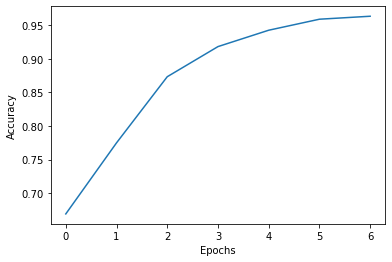

In [76]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Validation Accuracy')

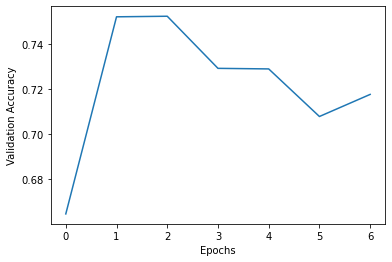

In [77]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [81]:
test_sequences = tokenizer.texts_to_sequences(data_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.evaluate(test_padded,y_test))


27/27 [==============================] - 1s 31ms/step - loss: 0.4554 - accuracy: 0.7860
[0.45542794466018677, 0.7860465049743652]


In [83]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_padded, batch_size= 128, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred = (y_pred>0.5)
print(classification_report(y_test, y_pred))

7/7 [==============================] - 1s 74ms/step
              precision    recall  f1-score   support

           0       0.65      0.50      0.57       240
           1       0.82      0.90      0.86       620

    accuracy                           0.79       860
   macro avg       0.74      0.70      0.71       860
weighted avg       0.77      0.79      0.78       860

